# 09. 4th Attempt with Learning from Wrong Answers 2

## 조금 더 친절한 오답노트

이전에 다시 학습중인 agent가 직접 게임을 진행하고
그 결과를 바탕으로 학습을 진행하는 방법을
적용하였습니다.
하지만 기보가 누적이 되어도 실제 행동이 저희가
원하는 방향으로 행동하도록 학습되지는 않았습니다.

그래서 여기서는 `agent_analysis_based`가
생각하는 합리적인 수를 같이 제공하여 학습하도록
해봅니다.

- 일단 여기서는 analysis based algorithm으로 생성되는
데이터는 사용하지 **않습니다**.
순수하게 model이 진행한 게임들로 학습을 진행합니다.
- 기보 하나를 학습하고 버릴 경우 batch size가 너무 작아지므로
몇 개의 batch를 저장하는 container를 만들어 두고, LRU를
제거하는 식으로 batch를 관리합니다.

## 환경설정

오목 학습에 필요한 모듈들을 모두 불러옵니다.

In [ ]:
!rm -rf mock5.py gen.cpp read_record.py gen mock5
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 129 (delta 58), reused 115 (delta 44), pack-reused 0
Receiving objects: 100% (129/129), 36.20 KiB | 12.07 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
from mock5.agent_random import agent as m5agent_random
from mock5.agent_analysis_based import agent as m5agent_a

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cuda


## 크기 설정

In [19]:
# Board Size
W = 11
H = W

## 신경망

In [20]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    return x.flatten(1, -1)

class FlatSum(torch.nn.Module):
  def forward(self, x):
    while len(x.shape) > 2:
      x = x.sum(dim=-1)
    return x.sum(dim=-1, keepdim=True)

In [21]:
LW = W // 2
model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding='same'),
    nn.LeakyReLU(1e-2),
    nn.Conv2d(64, 128, 3, padding='same'),
    nn.LeakyReLU(1e-2),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 128, 3, padding='same'),
    nn.LeakyReLU(1e-2),
    nn.Conv2d(128, 1, 3, padding='same'),
    nn.AvgPool2d(LW),
    Flatten(),
    nn.Tanh(),
).to(device)

loss_fn = nn.MSELoss()

In [22]:
def agent_model(game):
  idxs, Xs = game.tensors_with_a_stone()
  X = Xs.to(device)
  with torch.no_grad():
    y = model(X)
  j = torch.argmax(y)
  k = idxs[j]
  return (k // W), (k % W)

In [23]:
def agent_model_exp(game):
  idxs, Xs = game.tensors_with_a_stone()
  X = Xs.to(device)
  with torch.no_grad():
    y = model(X)
  j = torch.argmax(y)
  p = len(idxs)
  while p > 1 and np.random.random() < 0.1:
    y[j] = -1000
    j = torch.argmax(y)
    p -= 1
  k = idxs[j]
  return (k // W), (k % W)

## 실행용 함수

In [24]:
def run_game(agent1, agent2, random_first=True):
  game = Mock5(H, W)
  result = game.play(
      agent1, agent2,
      random_first=random_first,
      print_intermediate_state=False,
      print_messages=False)
  print(game)
  return game, result

In [25]:
def make_data_from_game(sz):
  Xs, Ys = [], []
  model_order = 0 if np.random.random() < 0.5 else 1
  for i in range(sz):
    model_order = (model_order + 1) % 2
    if model_order == 0:
      game, result = run_game(agent_model_exp, m5agent_a, random_first=False)
    else:
      game, result = run_game(m5agent_a, agent_model_exp, random_first=False)
    for angle in range(4):
      for flip in range(2):
        # Push game score
        g = game.replay(angle=angle, flip=flip)
        h = g.replay()
        w = 0
        if result == model_order + 1: w = 1
        else: w = -1
        while h.history_depth() >= 1:
          Xs.append(h.tensor(player=(model_order + 1), dtype=torch.float))
          Ys.append(w)
          Xs.append(h.tensor(player=(2 - model_order), dtype=torch.float))
          Ys.append(-w)
          h.undo()
        # Push hint
        if result == 2 - model_order: # When lose
          while g.history_depth() >= 2:
            g.undo()
            last = g.history[-1]
            g.undo() # Rewind just before model placed a stone
            r, c = m5agent_a(g) # Find hint
            if r * g.width + c == last: continue
            g.place_stone(r, c) # Just place
            Xs.append(g.tensor(player=(model_order + 1), dtype=torch.float))
            Ys.append(1)
            Xs.append(g.tensor(player=(2 - model_order), dtype=torch.float))
            Ys.append(-1)
            g.undo()
  X = torch.stack(Xs)
  Y = torch.tensor(Ys, dtype=torch.float).unsqueeze(1)
  return X, Y

## 학습

In [26]:
def learn_batch(opt, n_epoch, X, Y):
  log_int = max(1, min(50, int(n_epoch / 5)))
  acc_n, acc_loss = 0, 0
  acc_loss = 0

  print("-- Learn Batch --")
  torch.cuda.empty_cache()
  X = X.to(device)
  Y = Y.to(device)
  ys = torch.abs(Y).mean()

  for epoch in range(n_epoch):
    opt.zero_grad()
    Y_ = model(X)
    loss = loss_fn(Y_, Y)
    loss.backward()
    opt.step()

    acc_loss += loss.item() / ys.item()
    acc_n += 1

    if epoch % log_int == log_int - 1 or epoch == n_epoch - 1:
      print("E {:.3f}: Loss = {:.6f}".format(
          (epoch + 1) / n_epoch, acc_loss / acc_n))
      acc_loss, acc_n = 0, 0

In [27]:
MSs = 5
Xs = []
Ys = []

def learn_from_game(opt, ratio_epoch, sz):
  while len(Xs) >= MSs:
    del Xs[0]
    del Ys[0]
  X, Y = make_data_from_game(sz)
  Xs.append(X)
  Ys.append(Y)
  X = torch.cat(Xs, dim=0)
  Y = torch.cat(Ys, dim=0)
  print("Batch Size: {} (from game)".format(Y.shape[0]))
  return learn_batch(opt, max(1, int(ratio_epoch * Y.shape[0])), X, Y)

In [29]:
print("===== Main Learning =====")
opt = optim.Adam(
    model.parameters(),
    lr=4e-4,
    weight_decay=1e-6
)
for i in range(100):
  print("=== {}-th leran ===".format(i + 1))
  learn_from_game(opt, 0.002, 2)

 [ Turn  18 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . . . . X . .
3 | . . . X . . O O . . .
4 | . . . X . . O . . . .
5 | . . . X O O O X . . .
6 | . . . X O X X . . . .
7 | . . . X O O . . . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
Batch Size: 2632 (from game)
-- Learn Batch --
E 0.200: Loss = 0.907674
E 0.400: Loss = 0.900454
E 0.600: Loss = 0.891420
E 0.800: Loss = 0.879716
E 1.000: Loss = 0.870395
=== 21-th leran ===
 [ Turn   9 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . . . . . . .
3 | . . . . . . . . X . .
4 | . . . . . . . O . . .
5 | . . . . . . O . . . .
6 | . . . . . O X X . . .
7 | . . . . O X . . . . .
8 | . . . O . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
 [ Turn  26 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8

## 평가

In [45]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2,
                    print_intermediate_state=False, print_messages=False)
    if result == 1: w1 += 1
    elif result == 2: w2 += 1
  print("-- Test Result --")
  print("* Agent1 = {} \n* Agent2 = {}".format(agent1, agent2))
  print("Total: {}".format(num_game))
  print("A1 Win: {} ({:.3f})".format(w1, w1 / num_game))
  print("A2 Win: {} ({:.3f})".format(w2, w2 / num_game))

### v.s. Random

In [46]:
test_agents(50, m5agent_random, agent_model)

-- Test Result --
* Agent1 = <function agent at 0x7fc7fbeb07a0> 
* Agent2 = <function agent_model at 0x7fc73c15df80>
Total: 50
A1 Win: 0 (0.000)
A2 Win: 50 (1.000)


 [ Turn  11 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . X . . . .
1 | . . . . X . . . . . .
2 | . . . . . O X . . . .
3 | . . . . . O . . . . .
4 | X . . . . O O . . . .
5 | . . . . . O . . . . .
6 | . . . . . O . . . . .
7 | . . . . . . . . . . .
8 | . . . . . . . . . X .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
1p (<function agent_model at 0x7fc73c15df80>) win!


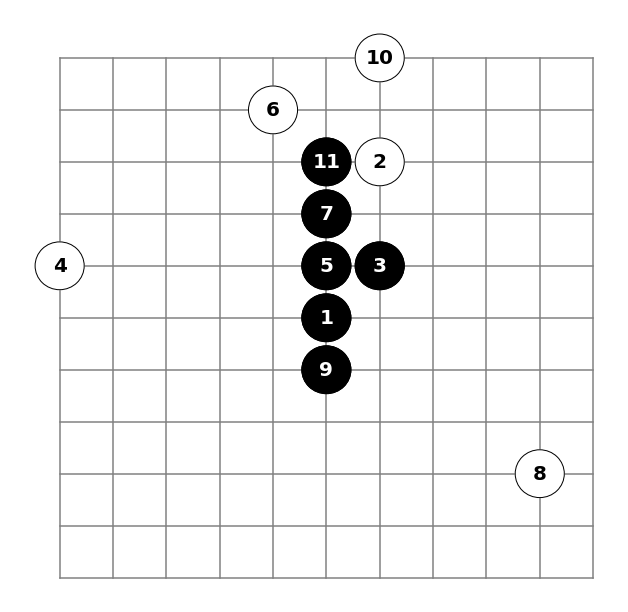

In [47]:
g = Mock5(H, W)
g.play(m5agent_random, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

### v.s. Analysis-based

Analysis-based agent와 신경망 모두 사실상 결정적으로
동작하므로, 여러 번 붙여볼 필요는 없습니다.

 [ Turn  26 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . O . . . . . . .
3 | . . . O X . . X . . .
4 | . . . X O X . . . . .
5 | . . O . O O X O . . .
6 | . . . . O O X O . . .
7 | . . . . . X O O . . .
8 | . . X . X X O X . . .
9 | . . . X . . . . . . .
A | . . X . . . . . . . .
2p (agent-analysis-based) win!


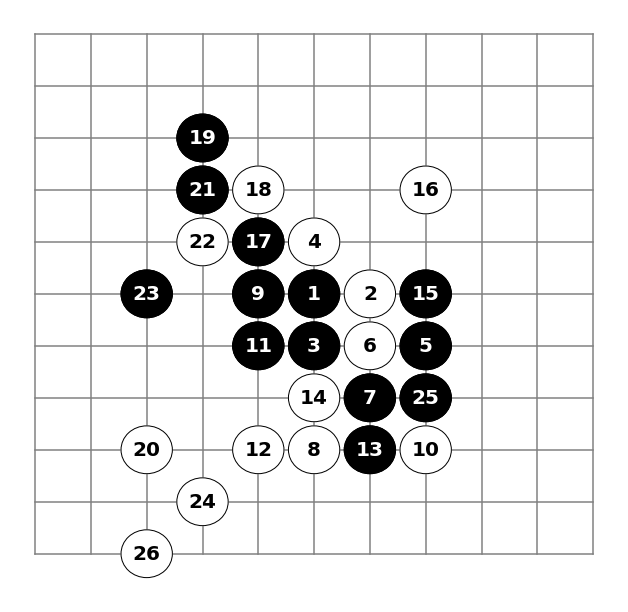

In [60]:
g = Mock5(H, W)
g.play(m5agent_a, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

### v.s. half-random

아래 agent는 `ep`의 확률로 랜덤으로 동작하고,
그 외에는 analysis-based로 동작합니다.

아래의 `ep = 0.45`는 현재 모델에 대해 대략
50:50의 승률을 보이는 parameter입니다.

In [68]:
def agent_half_random(ep):
  def agent_half_random(game):
    if np.random.random() < ep: return m5agent_random(game)
    else: return m5agent_a(game)
  return agent_half_random

In [71]:
test_agents(50, agent_half_random(0.45), agent_model)

-- Test Result --
* Agent1 = <function agent_half_random.<locals>.agent_half_random at 0x7fc6d0dbb4d0> 
* Agent2 = <function agent_model at 0x7fc73c15df80>
Total: 50
A1 Win: 24 (0.480)
A2 Win: 26 (0.520)


 [ Turn  26 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . O . . . . .
2 | . . . . O . O . . . .
3 | . . . . X . X . . . .
4 | . . . O X X X X O . .
5 | . . O . X O . X . . .
6 | . . . X X O O O X . .
7 | . . X . O O X O . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
2p (<function agent_model at 0x7fc73c15df80>) win!


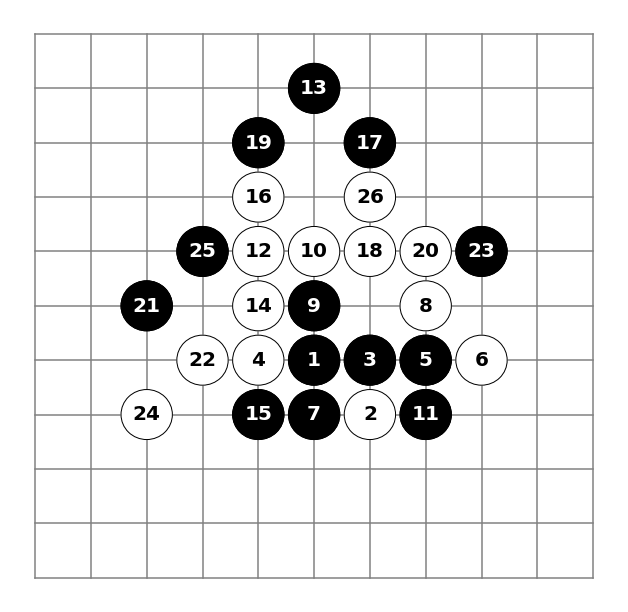

In [73]:
g = Mock5(H, W)
g.play(agent_half_random(0.45), agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

## 생각해볼 점

- 현재 신경망이 colab에서 생성하고 학습할 수 있는 한계에 가까운 크기입니다. 이보다 커질 경우 학습 데이터를 10개 기보 이상
올리지 못하게 됩니다.
다만 현재에도 학습 데이터에 따라 loss가 진동하는 경향을 보이는데,
이 문제는 complexity가 낮아서 발생하는 underfit으로
추정이 됩니다. 때문에 현재 방식으로 계속 진행할 경우에는
하드웨어를 개선하지 않는 한 성능 개선에 무리가 있을 수도
있다고 생각됩니다.
이 문제 때문에 다른 인코딩을 사용하는 등
메모리 문제를 개선해야 하지 않나 싶습니다.
- 기존의 방식들이 오랜 시간 동안 간신히 돌을 잇는데 반해,
현재 모델은 analysis-based 상대로도 나름 공방을 시도해보는
첫 결과물입니다.
- 보통 판단에 미스가 생기는 경우는 특정 줄에 2가지 색이
섞여있는 경우로 보입니다. 예를 들자면 검정 돌 사이에
흰색 돌이 들어가 끊어진 경우라든가, 흰색 돌이 이어지다가
검은 돌 벽에 막히는 경우 등이 있겠습니다.
이런 경우에 끊어졌다든가 막혔다는 것을 제대로 인식하지
못하고 돌을 잇는 경우가 자주 생기는 듯 합니다.
- 단순히 value network만으로 최대값을 찾아서 탐색하는 방식으로는
더 이상 정확한 수를 계산하지 못하는 것 같습니다.
이것이 학습이 잘 안 되어서 그런 것인지,
학습과 별개로 최선의 수가 안 나오는 것인지
생각해볼 필요가 있을 것 같습니다.